In [1]:
import pandas as pd
import numpy as np
from functools import reduce

DISPLAY_ALL_TEXT = False
pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

In [2]:
%matplotlib inline

import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spam")

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

In [3]:
from utils import load_spam_dataset

df_train, df_test = load_spam_dataset()

# We pull out the label vectors for ease of use later
Y_test = df_test.label.values

/home/tibvyasa/miniconda3/envs/snorkel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
Y_test.shape, df_test.shape

((250,), (250, 5))

In [5]:
ABSTAIN = -1
HAM = 0
SPAM = 1

In [6]:
df_train[['video']].describe(include='all')

,video
count,1586.000000
mean,2.620429
std,1.114713
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,4.000000


In [7]:
from collections import Counter
cnt1 = Counter(df_train['video'].iloc[0:int(1586/2)])
cnt2 = Counter(df_train['video'].iloc[int(1586/2):])
cnt1, cnt2

(Counter({1: 350, 2: 350, 3: 93}), Counter({3: 345, 4: 448}))

In [9]:
# mean
print("Mean:{}, Std:{}".format(reduce(lambda a,b:a+b,[key*value for key, value in cnt1.items()])/df_train.shape[0],\
                               np.std(df_train['video'])))

Mean:0.8379571248423707, Std:1.1143617393079197


<AxesSubplot: >

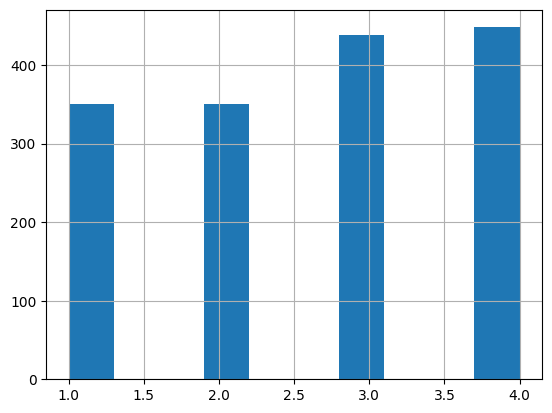

In [10]:
df_train['video'].hist()

In [11]:
df_train[["author", "text", "video"]].sample(20, random_state=2)

,author,text,video
4,ambareesh nimkar,"""eye of the tiger"" ""i am the champion"" seems l...",2
87,pratik patel,"mindblowing dance.,.,.superbbb song﻿",3
14,RaMpAgE420,Check out Berzerk video on my channel ! :D,4
80,Jason Haddad,"Hey, check out my new website!! This site is a...",1
104,austin green,Eminem is my insperasen and fav﻿,4
305,M.E.S,hey guys look im aware im spamming and it piss...,4
22,John Monster,Οh my god ... Roar is the most liked video at ...,2
338,Alanoud Alsaleh,I started hating Katy Perry after finding out ...,2
336,Leonardo Baptista,http://www.avaaz.org/po/petition/Youtube_Corpo...,1
143,UKz DoleSnacher,Remove This video its wank﻿,1


In [12]:
from snorkel.labeling import labeling_function


@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN


@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

In [13]:
from snorkel.labeling import PandasLFApplier

lfs = [check_out, check]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:00<00:00, 50231.56it/s]


In [14]:
coverage_check_out, coverage_check = (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.4f}%")
print(f"check coverage: {coverage_check * 100:.4f}%")

check_out coverage: 21.4376%
check coverage: 25.7881%


In [15]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.214376,0.0


In [16]:
df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=1)

,author,date,text,label,video
305,M.E.S,NaN,hey guys look im aware im spamming and it piss...,-1.0,4
265,Kawiana Lewis,2015-02-27T02:20:40.987000,Check out this video on YouTube:opponents mm <...,-1.0,3
89,Stricker Stric,NaN,eminem new song check out my videos,-1.0,4
147,TheGenieBoy,NaN,check out fantasy music right here -------&...,-1.0,4
240,Made2Falter,2014-09-09T23:55:30,"Check out our vids, our songs are awesome! And...",-1.0,2
273,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,-1.0,2
94,Nick McGoldrick,2014-10-27T13:19:06,Check out my drum cover of E.T. here! thanks -...,-1.0,2
139,MFkin PRXPHETZ,2014-01-20T09:08:39,"if you like raw talent, raw lyrics, straight r...",-1.0,1
303,이 정훈,NaN,"This great Warning will happen soon. ,0\nLneaD...",-1.0,4
246,media.uploader,NaN,Check out my channel to see Rihanna short mix ...,-1.0,4


In [17]:
from snorkel.analysis import get_label_buckets

buckets = get_label_buckets(L_train[:, 0], L_train[:, 1])
df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,author,date,text,label,video
403,ownpear902,2014-07-22T18:44:36.299000,check it out free stuff for watching videos an...,-1.0,3
256,PacKmaN,2014-11-05T21:56:39,check men out i put allot of effort into my mu...,-1.0,1
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
282,CronicleFPS,2014-11-06T03:10:26,Check me out I'm all about gaming ﻿,-1.0,1
352,MrJtill0317,NaN,┏━━━┓┏┓╋┏┓┏━━━┓┏━━━┓┏┓╋╋┏┓ ┃┏━┓┃┃┃╋┃┃┃┏━┓┃┗┓┏...,-1.0,4
161,MarianMusicChannel,2014-08-24T03:57:52,"Hello! I'm Marian, I'm a singer from Venezuela...",-1.0,2
270,Kyle Jaber,2014-01-19T00:21:29,Check me out! I'm kyle. I rap so yeah ﻿,-1.0,1
292,Soundhase,2014-08-19T18:59:38,Hi Guys! check this awesome EDM &amp; House mi...,-1.0,2
179,Nerdy Peach,2014-10-29T22:44:41,Hey! I'm NERDY PEACH and I'm a new youtuber an...,-1.0,2
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1


In [18]:
buckets

{(-1, -1): array([   0,    1,    4, ..., 1578, 1579, 1582]),
 (-1,
  1): array([   2,    3,   16,   21,   38,   39,   40,   47,   48,   71,   82,
          99,  103,  107,  112,  114,  136,  139,  146,  159,  162,  164,
         167,  178,  188,  190,  196,  201,  230,  239,  242,  256,  260,
         261,  266,  270,  282,  286,  288,  305,  322,  345,  353,  415,
         429,  449,  472,  511,  515,  529,  535,  541,  563,  612,  623,
         630,  642,  670,  683,  815,  925,  980, 1009, 1103, 1146, 1490,
        1510, 1554, 1584]),
 (1,
  1): array([  12,   31,   41,   46,   80,   81,   89,   92,  101,  123,  124,
         125,  170,  172,  268,  289,  303,  326,  332,  409,  410,  430,
         444,  451,  480,  514,  534,  588,  590,  602,  609,  633,  653,
         660,  664,  693,  696,  699,  701,  704,  705,  706,  709,  713,
         714,  715,  717,  719,  722,  727,  728,  729,  732,  734,  739,
         741,  742,  744,  745,  747,  752,  753,  754,  755,  756,  759,
  

In [19]:
import re

@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

In [20]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:00<00:00, 29029.24it/s]


In [21]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
regex_check_out,2,[1],0.233922,0.233922,0.0


In [22]:
buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=1)

,author,date,text,label,video
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1
99,Santeri Saariokari,2014-09-03T16:32:59,"Hey guys go to check my video name ""growtopia ...",-1.0,2
21,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,-1.0,1
239,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,-1.0,1
288,Kochos,2014-01-20T17:08:37,i check back often to help reach 2x10^9 views ...,-1.0,1
65,by.Ovskiy,2014-10-13T17:09:46,"Rap from Belarus, check my channel:)﻿",-1.0,2
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
333,FreexGaming,2014-10-18T08:12:26,want to win borderlands the pre-sequel? check ...,-1.0,2
167,Brandon Pryor,2014-01-19T00:36:25,I dont even watch it anymore i just come here ...,-1.0,1
266,Zielimeek21,2013-11-28T21:49:00,I'm only checking the views﻿,-1.0,1


In [23]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [24]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

In [25]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

In [26]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)

100%|██████████| 1586/1586 [00:01<00:00, 1549.10it/s]


In [27]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[0],0.035309,0.013871,0.0
textblob_subjectivity,1,[0],0.357503,0.013871,0.0


In [28]:
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

In [29]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

In [30]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

In [31]:
@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

In [32]:
from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

In [33]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

In [34]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 250/250 [00:02<00:00, 114.92it/s]


In [35]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.198613,0.186003,0.109710
keyword_subscribe,1,[1],0.127364,0.109079,0.069357
keyword_http,2,[1],0.119168,0.099622,0.080706
keyword_please,3,[1],0.112232,0.109710,0.056116
keyword_song,4,[0],0.141866,0.112232,0.043506
regex_check_out,5,[1],0.233922,0.128625,0.082598
short_comment,6,[0],0.225725,0.146280,0.074401
has_person_nlp,7,[0],0.074401,0.057377,0.022699
textblob_polarity,8,[0],0.035309,0.030895,0.005044
textblob_subjectivity,9,[0],0.357503,0.259142,0.160151


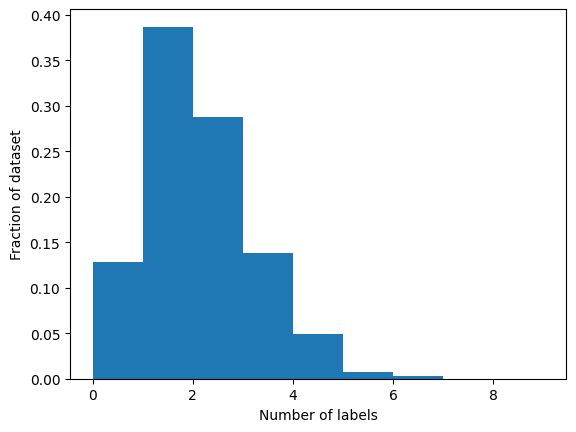

In [36]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

In [37]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [44]:
preds_train.shape

(1586,)

In [ ]:
majority_model.score()

In [39]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.163]
INFO:root:[100 epochs]: TRAIN:[loss=0.011]
100%|██████████| 500/500 [00:00<00:00, 1318.12epoch/s]
INFO:root:Finished Training


In [45]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   83.6%
Label Model Accuracy:     86.4%


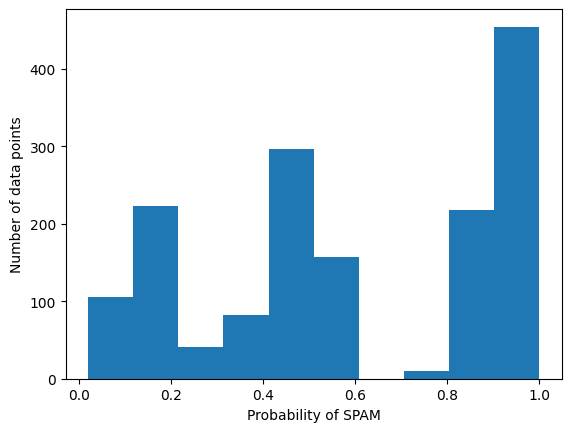

In [46]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

In [51]:
L_train.shape, probs_train.shape

((1586, 10), (1586, 2))

In [52]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [53]:
df_train_filtered.shape, probs_train_filtered.shape

((1383, 5), (1383, 2))

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

In [ ]:
X_train.shape, X_test.shape

In [ ]:
vectorizer.get_feature_names_out().shape

In [55]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [59]:
probs_train_filtered[0:10], preds_train_filtered[0:10]

(array([[6.57585026e-01, 3.42414974e-01],
        [4.97710295e-06, 9.99995023e-01],
        [8.93995003e-01, 1.06004997e-01],
        [6.96360610e-01, 3.03639390e-01],
        [6.96360610e-01, 3.03639390e-01],
        [4.69261092e-01, 5.30738908e-01],
        [1.99865534e-08, 9.99999980e-01],
        [1.40626618e-02, 9.85937338e-01],
        [2.09204025e-04, 9.99790796e-01],
        [6.29352446e-01, 3.70647554e-01]]),
 array([0, 1, 0, 0, 0, 1, 1, 1, 1, 0]))